In [1]:
%load_ext autoreload
%autoreload 2

from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
import numpy as np
import pickle
from jax import jit
from tqdm.notebook import tqdm
import jax.numpy as jnp

import jaxley as jx

import sys
sys.path.append("../scripts/")

from colors import cols as papercols
from EI_stimulus import gen_stim
from network import initialize_RNN
from raster_sort import fft_max_sort
from psycho_curve import fit_curve, logistic

In [2]:
time_stamp = "0802-114242" # for the figure

### Initial Dynamics (b)

In [3]:
with open(f"../results/evint_init_params_{time_stamp}.pkl", "rb") as f:
    init_conn_matrix, init_input_weights, RNN_params = pickle.load(f)

In [4]:
network, conn_matrix, init_input_weights = initialize_RNN(RNN_params)

3.45
69
20
conn probability recurrence: 0.17250000000000001
EIratio:1.0
Normaliser: 1.0598888663568604
Spectral radius recurrence: 0.0033942856019830285


In [5]:
# Check that the connectivity matrix is the same as what was pickled
np.all(conn_matrix == init_conn_matrix)

True

Init gain 0.003141592653589793


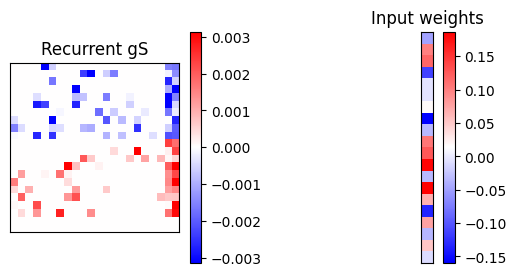

In [6]:
init_gain = RNN_params["init_gain"]
print(f"Init gain {init_gain}")

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
gS_rec = axs[0].matshow(conn_matrix, vmin=-init_gain, vmax=init_gain, cmap="bwr")
inp_ws = axs[1].matshow(init_input_weights[0]["input_weights"][:, np.newaxis], cmap="bwr")

axs[0].set_title("Recurrent gS")
plt.colorbar(gS_rec, ax=axs[0])
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].set_title("Input weights")
plt.colorbar(inp_ws, ax=axs[1])
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

In [7]:
network.delete_trainables()
network.IonotropicSynapse("all").make_trainable("IonotropicSynapse_gS")

params = network.get_parameters()
params = init_input_weights + params

Number of newly added trainable parameters: 109. Total number of trainable parameters: 109


In [8]:
network.delete_recordings()

n_cells = RNN_params["n_rec"]
n_readouts = RNN_params["n_out"]
for i in range(n_cells):
    network.cell([i]).branch(1).comp(0).record(verbose=False)
# Record from the readout (only one branch)
for i in range(n_readouts):
    network.cell([n_cells+i]).branch(0).comp(0).record(verbose=False)

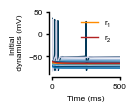

In [9]:
# Do the initial acitivity plot specifically for this network
v = jx.integrate(network, t_max=520, delta_t=0.025, solver="bwd_euler")

ramp_up_ms = 20
ramp_up = int(ramp_up_ms / 0.025)
total_time = 500
time = np.arange(0, total_time, 0.025)

colors = plt.cm.Blues(np.linspace(0, 1, v.shape[0]-1))
readout_colors = ["darkorange", "firebrick"]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.25, 1.0), constrained_layout=True)

    ax.set_prop_cycle('color', papercols["jaxley_shades"])
    for i in range(v.shape[0]-2):
        ax.plot(time, v[i, ramp_up:-1], alpha=1.0)
    ax.plot(time, v[-2, ramp_up:-1].T, color=readout_colors[0], label=r"$r_1$")
    ax.plot(time, v[-1, ramp_up:-1].T, color=readout_colors[1], label=r"$r_2$")
    ax.legend()
    ax.set_ylabel("Initial \n dynamics (mV)")
    ax.set_xlabel("Time (ms)")
    sns.despine(offset=2)
    ax.set_xlim((0, total_time))
    ax.set_ylim((-90, 50))
    ax.set_xticks([0, total_time])

    #plt.savefig("../figures/init_traces_EI.svg", transparent=True)
    plt.show()

### Results (c)

In [10]:
with open(f"../results/evint_params_{time_stamp}.pkl", "rb") as f:
    params, task_params, RNN_params, train_params = pickle.load(f)

In [11]:
task_params

{'dt': 0.025,
 'loss': 'CE',
 'response_length': 20,
 'response_time': 500,
 'stim_freq_max': 2500,
 'stim_mean': [-0.005, 0.005],
 'stim_mean_std': 0.0002,
 'stim_std': 0.05,
 'target_pol': 0,
 'total_time': 520}

In [12]:
RNN_params

{'RNN_seed': 3,
 'in_conn_prob': 1,
 'init_gain': 0.003141592653589793,
 'inp_scale': 0.1,
 'k_minus': 1,
 'n_inh': 10,
 'n_out': 2,
 'n_rec': 20,
 'out_conn_prob': 1,
 'out_k_minus': 0.025,
 'out_scale': 1,
 'rec_conn_prob': 0.2}

In [13]:
train_params

{'batch_size': 4,
 'checkpoint_levels': 3,
 'lowers': {'IonotropicSynapse_gS': 1e-10, 'input_weights': -0.1},
 'lr': 0.01,
 'n_epochs': 2000,
 'train_seed': 568,
 'trainables': ['IonotropicSynapse_gS'],
 'uppers': {'IonotropicSynapse_gS': 0.01, 'input_weights': 0.1}}

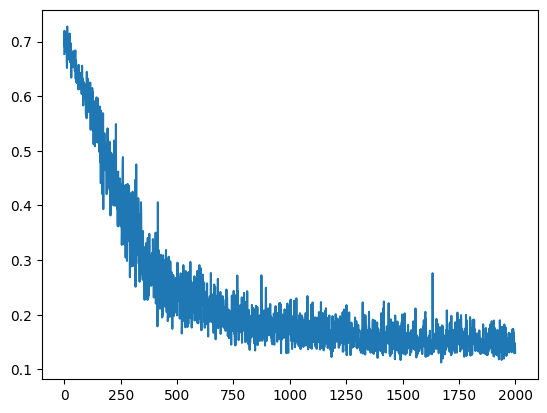

In [14]:
with open(f"../results/evint_losses_{time_stamp}.pkl", "rb") as handle:
    losses = pickle.load(handle)

plt.plot(losses)

In [15]:
# Same as the function used in evidence_integration_longer.py, can put in its own file
def simulate(params, stim):
    input_weights = params[0]["input_weights"]
    syn_weights = params[1:]
    #syn_weights = params

    data_stimuli = None
    for i, w in zip(range(n_cells), input_weights):
        data_stimuli = network.cell(i).branch(2).comp(0).data_stimulate(
                stim * w, data_stimuli=data_stimuli
                )

    v = jx.integrate(
        network,
        delta_t=task_params["dt"],
        params=syn_weights,
        data_stimuli=data_stimuli,
        solver="bwd_euler",
    )
    return v

jitted_simulate = jit(simulate)

In [16]:
def softmax(x, axis=0):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def loss_from_response(response, mask, label, n_readouts=2):
    readouts = response[-n_readouts:, 1:]
    readout_mean = np.mean(mask*readouts, axis=1)
    readout_softmax = softmax(readout_mean)
    return -np.sum(label * np.log(readout_softmax))


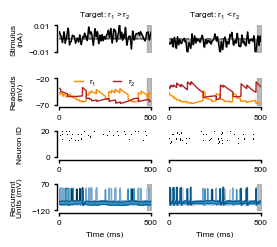

In [17]:
_ = np.random.seed(3)
ramp_up_ms = 20
ramp_up = int(ramp_up_ms / task_params["dt"])
axis_lim = task_params["total_time"] - ramp_up_ms

with mpl.rc_context(fname="../../../.matplotlibrc"):

    fig, ax = plt.subplots(4, 2, figsize=(2.6, 2.4))
    colors = ["darkorange", "firebrick"]

    for  i, mean in enumerate([0.002, -0.002]):
        task_params["stim_mean"] = [mean, mean] # both either the positive or the negative   
        stim, target, mask, offsets = gen_stim(task_params, return_offsets=True)
        time = np.arange(0, stim.shape[0]) * task_params["dt"]
        time = time[ramp_up:] - ramp_up_ms
        
        # Stimulus plot
        ax[0, i].plot(time, stim[ramp_up:], color="k")
        ax[0, i].plot(
            time,
            np.zeros_like(time),
            color="grey",
            zorder=-10,
            ls="--",
        )
        ax[0, i].set_xticks([])
        ax[0, i].set_xlim([0, time[-1]])
        ax[0, i].set_yticks([-0.01, 0.01])
        ax[0, i].set_ylim([-0.01, 0.01])
        sns.despine(bottom=True, offset=2, ax=ax[0, i])
        sign = np.sign(offsets)
        response_time_dt = int(task_params["response_time"] / task_params["dt"])
        rect_ys = np.where(np.sign(stim) == sign, stim, 0) 
        ax[0, i].fill_between(time[:(response_time_dt-ramp_up)], rect_ys[ramp_up:response_time_dt], 0, color="k", alpha=0.3)
        y1_st = -0.01
        y2_st = 0.01
        ax[0, i].fill_between(
            x=[task_params["response_time"] - 20, task_params["response_time"] + task_params["response_length"] - 20],
            y1=y1_st,
            y2=y2_st,
            alpha=0.5,
            label="Response",
            color="grey",
        )
        # Write what the target should be
        ax[0, 0].set_title(r"Target: $r_1 > r_2$")
        ax[0, 1].set_title(r"Target: $r_1 < r_2$")

        v = jitted_simulate(params, stim)

        # Raster plot of network activity
        raster = (v[:-n_readouts, :-1] > -50.0).astype(int)
        if i == 0:
            # sort the first raster
            raster, sort_order = fft_max_sort(raster)
        else:
            # sort the second raster same as the first
            raster = raster[sort_order]

        ax[2, i].imshow(raster[:, ramp_up:-1], aspect="auto", cmap="binary", origin="lower")

        ax[2, i].set_yticks([0, raster.shape[0]], [0, raster.shape[0]])
        ax[2, i].set_xticks([0, raster.shape[1]], [0, axis_lim])
        sns.despine(offset=2, ax=ax[1, i])
        ax[2, i].spines["left"].set_bounds([0, raster.shape[0]])
        ax[2, i].spines["bottom"].set_bounds([0, raster.shape[1]])

        # Individual responses
        ax[3, i].set_prop_cycle('color', papercols["jaxley_shades"])
        ax[3, i].plot(time, v[:-n_readouts, ramp_up:-1].T)
        y1_st = -120
        y2_st = 70
        ax[3, i].fill_between(
            x=[task_params["response_time"] - 20, task_params["response_time"] + task_params["response_length"] - 20],
            y1=y1_st,
            y2=y2_st,
            alpha=0.5,
            label="Response",
            color="grey",
        )
        ax[3, i].set_xticks([0, axis_lim])
        ax[3, i].set_yticks([y1_st, y2_st])
        ax[3, i].set_xlim([0, axis_lim])
        ax[3, i].set_ylim([y1_st, y2_st])
        sns.despine(offset=2, ax=ax[2, i])

        # Readout traces
        r1 = ax[1, i].plot(time, v[-2, ramp_up:-1].T, color=colors[0], label=r"$r_1$")
        r2 = ax[1, i].plot(time, v[-1, ramp_up:-1].T, color=colors[1], label=r"$r_2$")

        y1_st = -70
        y2_st = -20
        ax[1, i].fill_between(
            x=[task_params["response_time"] - ramp_up_ms, task_params["response_time"] + task_params["response_length"] - 20],
            y1=y1_st,
            y2=y2_st,
            alpha=0.5,
            #label="Response period",
            color="grey",
        )
        ax[1, i].set_yticks([y1_st, y2_st])
        ax[1, i].set_ylim([y1_st, y2_st])
        ax[1, i].set_xticks([0, axis_lim])
        ax[1, i].set_xlim([0, axis_lim])
        ax[3, i].set_xlabel("Time (ms)")
        sns.despine(offset=2, ax=ax[3, i])

        # Remove y axes on right plots to save space
        if i==1:
            # remove the y axes on the righ plots to save space
            for i in range(4):
                ax[i, 1].set_yticks([])
                sns.despine(left=True, ax=ax[i, 1])
            sns.despine(left=True, bottom=True, ax=ax[0, 1])

    # Legend
    ax[1, 0].legend(frameon=False, loc="upper center", ncol=2, handlelength=1, bbox_to_anchor=(0.5, 1.3))

    # ylabels
    ax[0, 0].set_ylabel("Stimulus\n(nA)")
    ax[2, 0].set_ylabel("Neuron ID")
    ax[3, 0].set_ylabel("Recurrent\nUnits (mV)")
    ax[1, 0].set_ylabel("Readouts\n(mV)")
    fig.align_ylabels(ax[:, 0])

    fig.subplots_adjust(hspace=1.0, wspace=0.2)

    plt.savefig("../figures/ev_int.svg", bbox_inches="tight", transparent=True)
    #plt.savefig("../figures/ev_int.png", dpi=300, bbox_inches="tight")
    plt.show()

In [18]:
# Check the final loss again
def predict(params, stim):
    v = simulate(params, stim)
    return v[-n_readouts:, 1:]

def CE_loss(params, stim, label, mask):
    pred = predict(params, stim)
    # Average activity of both of the readouts in the response period
    response = np.mean(mask*pred, axis=1)
    # Softmax the response activations
    response = softmax(response)
    # Give the cross entropy loss
    return -np.sum(label * np.log(response))

task_params["stim_mean"] = [-0.002, 0.002]
stim, target, mask = gen_stim(task_params)
print(target)
CE_loss(params, stim, target, mask)

[0 1]


0.6844109395442985

### Final connectivity matrix

In [19]:
with open(f"../results/evint_final_conn_{time_stamp}.pkl", "rb") as f:
    final_conn_matrix = pickle.load(f)

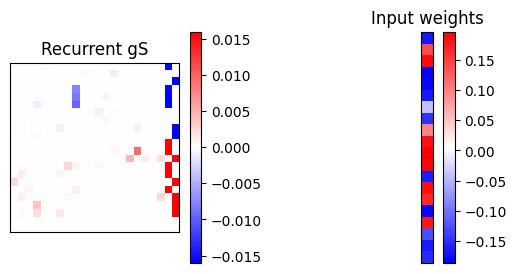

In [20]:
max_w = np.max(np.abs(final_conn_matrix))

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
gS_rec = axs[0].matshow(final_conn_matrix, vmin=-max_w, vmax=max_w, cmap="bwr")
inp_ws = axs[1].matshow(params[0]["input_weights"][:, np.newaxis], cmap="bwr")

axs[0].set_title("Recurrent gS")
plt.colorbar(gS_rec, ax=axs[0])
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].set_title("Input weights")
plt.colorbar(inp_ws, ax=axs[1])
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

### Psychometric Curve (d)

In [21]:
def positive_choices(response, target):
    mean_response = np.mean(response, axis=1)
    mean_response = np.argmax(softmax(mean_response))
    # Only correct if they match
    if mean_response == 0:
        # This means that readout 1 was more depolarized than readout 2
        return 1
    else:
        return 0 
    
def correct_choices(response, target):
    readouts = response[-n_readouts:, 1:]
    readout_mean = np.mean(mask*readouts, axis=1)
    readout_softmax = softmax(readout_mean)
    decision = np.argmax(readout_softmax)
    target = np.argmax(target)
    if decision == target:
        return 1
    else:
        return 0

In [22]:
# Calculate the final accuracy under the training conditions
task_params["stim_mean"] = [-0.005, 0.005]
print(task_params)

n_trials = 1000
choices = np.zeros(n_trials)
for i in tqdm(range(n_trials)):
    stim, target, mask = gen_stim(task_params)
    v = jitted_simulate(params, stim)
    choices[i] = correct_choices(v, target)
print(np.sum(choices) / n_trials)

{'dt': 0.025, 'loss': 'CE', 'response_length': 20, 'response_time': 500, 'stim_freq_max': 2500, 'stim_mean': [-0.005, 0.005], 'stim_mean_std': 0.0002, 'stim_std': 0.05, 'target_pol': 0, 'total_time': 520}


  0%|          | 0/1000 [00:00<?, ?it/s]

0.999


In [23]:
# # Get the fraction of accurate responses
# print(task_params)
# mean_range = np.arange(-0.005, 0.005, step=0.0005)
# frac_pos = []
# se = []
# response_time_dt = int(task_params["response_time"] / task_params["dt"])
# response_length_dt = int(task_params["response_length"] / task_params["dt"])

# for mew in tqdm(mean_range):
#     trials = np.zeros(100)
#     for i in range(100):
#         task_params["stim_mean"] = [mew, mew]
#         stim, target, mask = gen_stim(task_params)
#         v = jitted_simulate(params, stim)
#         response = v[-n_readouts:, response_time_dt:response_time_dt+response_length_dt]
#         choice = positive_choices(response, target)
#         trials[i] = choice
#     frac = np.mean(trials)
#     frac_pos.append(frac)
#     se.append(np.sqrt(frac*(1-frac)/100))

In [24]:
# f = open(f"../results/psychometric_curve_data_{task_params['response_time']}ms_{time_stamp}.pkl", "wb")
# pickle.dump((mean_range, frac_pos, se), f)
# f.close()

In [25]:
with open(f"../results/psychometric_curve_data_{task_params['response_time']}ms_{time_stamp}.pkl", "rb") as handle:
    mean_range, frac_pos, se = pickle.load(handle)

In [26]:
curve_params = fit_curve(jnp.array(mean_range), jnp.array(frac_pos))

it 0.0, loss 0.014775265750583714
it 0.05, loss 0.010019211305290784
it 0.1, loss 0.007377685964463886
it 0.15, loss 0.005487392247973895
it 0.2, loss 0.0038412163161892945
it 0.25, loss 0.0027361984355914423
it 0.3, loss 0.0025631800818442393
it 0.35, loss 0.001408016236743639
it 0.4, loss 0.0013383478456178077
it 0.45, loss 0.0010775536233640019
it 0.5, loss 0.0008627201557802006
it 0.55, loss 0.003255847292794468
it 0.6, loss 0.0017859219511495252
it 0.65, loss 0.0008280054637343423
it 0.7, loss 0.0008321502189782243
it 0.75, loss 0.0008904468385962654
it 0.8, loss 0.0008316120254507731
it 0.85, loss 0.004498463330011184
it 0.9, loss 0.0009570630510194887
it 0.95, loss 0.0008312324033623339
{'a': Array(973.40284937, dtype=float64), 'b': Array(0.00039838, dtype=float64)}


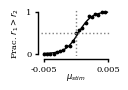

In [27]:
test_means = np.arange(-0.005, 0.005, step=0.0001)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(figsize=(0.9, 0.6))

    ax.scatter(mean_range, frac_pos, c="k", s=3)

    ax.plot(test_means, logistic(curve_params, test_means), c="k")

    ax.set_xlabel(r"$\mu_{stim}$", labelpad=-1)
    ax.set_ylabel(r"Frac. $r_1 > r_2$")

    ax.set_yticks([0, 1], [0, 1])
    ax.set_xticks([-0.005, 0.005], [-0.005, 0.005])

    ax.axvline(0, linestyle="dotted", color="grey")
    ax.axhline(0.5, linestyle="dotted", color="grey")

    ax.spines["bottom"].set_bounds([-0.005, 0.005])
    ax.spines["left"].set_bounds([0, 1])

    sns.despine(offset=2)

    plt.savefig("../figures/psychometric_fit.svg", transparent=True, bbox_inches="tight")

### Generalization (e)

In [28]:
task_params = {
    "dt": 0.025,
    "total_time": 3_020,
    "response_time": 3_000,
    "response_length": 20,
    "target_pol": 0,
    "stim_std": 0.05,
    "stim_mean": [-0.005, 0.005],
    "stim_mean_std": 0.0002,
    "stim_freq_max": 2500,
    "loss": "CE"
}

# Get the positive example
task_params["stim_mean"] = [0.002, 0.002]
stim, target, mask = gen_stim(task_params)
pos_long = jitted_simulate(params, stim)

# Get the negative example
task_params["stim_mean"] = [-0.002, -0.002]
stim, target, mask = gen_stim(task_params)
neg_long = jitted_simulate(params, stim)

# Cut the data for plotting
ramp_up = int(20 / task_params["dt"])
time = np.arange(0, stim.shape[0]-ramp_up) * task_params["dt"]

# Cut off the ramp up period
pos_long = pos_long[:, ramp_up:-1]
neg_long = neg_long[:, ramp_up:-1]

# Cut out 30 ms - 2970 ms
first_cut = int(30 / task_params["dt"])
second_cut = int((2970 - 20) / task_params["dt"])
pos_long = np.concatenate((pos_long[:, :first_cut], pos_long[:, second_cut:]), axis=1)
neg_long = np.concatenate((neg_long[:, :first_cut], neg_long[:, second_cut:]), axis=1)
time = np.concatenate((time[:first_cut], time[second_cut:]))


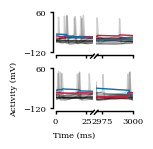

In [29]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(2, 2, figsize=(1.0, 1.25))

    colors = ["crimson", papercols["jaxley"]]

    for i in range(2):
        ax[0, i].plot(time, pos_long[:-n_readouts].T, color="k", alpha=0.2)
        ax[0, i].plot(time, pos_long[-2], color=colors[0])
        ax[0, i].plot(time, pos_long[-1], color=colors[1])

        ax[1, i].plot(time, neg_long[:-n_readouts].T, color="k", alpha=0.2)
        ax[1, i].plot(time, neg_long[-2], color=colors[0])
        ax[1, i].plot(time, neg_long[-1], color=colors[1])

        ax[i, 0].set_xlim((0, 30))
        ax[i, 1].set_xlim((2970, 3000))

        ax[0, i].set_xticklabels([])

        ax[i, 0].set_ylim((-120, 60))
        ax[i, 1].set_ylim((-120, 60))

        # Hide the axis spines
        ax[i, 0].spines['right'].set_visible(False)
        ax[i, 1].spines['left'].set_visible(False)
        ax[i, 1].set_yticks([])
        ax[i, 0].set_yticks([-120, 60])

        ax[1, 0].set_xlabel("Time (ms)")
        ax[1, 0].set_ylabel("Activity (mV)")

        sns.despine(offset=2, ax=ax[i, 0])
        sns.despine(offset=2, ax=ax[i, 1], left=True)

        d = .05  # how big to make the diagonal lines in axes coordinates
        # arguments to pass plot, just so we don't keep repeating them
        kwargs = dict(transform=ax[i, 0].transAxes, color='k', clip_on=False)
        ax[i, 0].plot((1-d, 1+d), (-d-2*d, +d-2*d), **kwargs)

        kwargs.update(transform=ax[i, 1].transAxes)  # switch to the bottom axes
        ax[i, 1].plot((-d, +d), (-d-2*d, +d-2*d), **kwargs)

        fig.subplots_adjust(wspace=0.1, hspace=0.4)
        #plt.savefig("../figures/ev_int_long.svg", transparent=True)
        

Loss: 0.6437216749813959
(20, 2400)
(20, 2400)
Loss: 0.6100707578485192
(20, 2400)
(20, 2400)


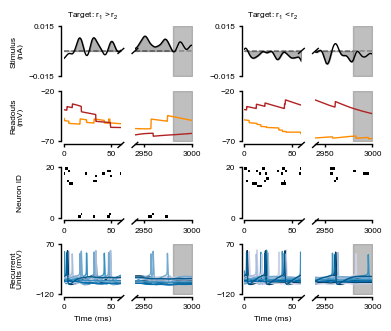

In [35]:
_ = np.random.seed(0)
ramp_up_ms = 20
ramp_up = int(ramp_up_ms / task_params["dt"])
axis_lim = task_params["total_time"] - ramp_up_ms
raster_lims = [int(60/task_params["dt"]), int(2940/task_params["dt"])]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(4, 4, figsize=(3.8, 3.2), constrained_layout=True)
    colors = ["darkorange", "firebrick"]

    for mean in [0.002, -0.002]:
        task_params["stim_mean"] = [mean, mean] # both either the positive or the negative   
        stim, target, mask, offsets = gen_stim(task_params, return_offsets=True)
        time = np.arange(0, stim.shape[0]) * task_params["dt"]
        time = time[ramp_up:] - ramp_up_ms
        v = jitted_simulate(params, stim)
        print(f"Loss: {loss_from_response(v, mask, target)}")
        
        if mean > 0:
            inds = [0, 1]
        else:
            inds = [2, 3]
        for f, i in enumerate(inds):
            # Stimulus plot
            ax[0, i].plot(time, stim[ramp_up:], color="k")
            ax[0, i].plot(
                time,
                np.zeros_like(time),
                color="grey",
                zorder=-10,
                ls="--",
            )
            ax[0, i].set_xticks([])
            ax[0, i].set_yticks([-0.015, 0.015])
            ax[0, i].set_ylim([-0.015, 0.015])
            sns.despine(bottom=True, offset=2, ax=ax[0, i])
            sign = np.sign(offsets)
            response_time_dt = int(task_params["response_time"] / task_params["dt"])
            rect_ys = np.where(np.sign(stim) == sign, stim, 0)
            if f == 0:
                # fill in the first part of the stimulus
                fill_time = time[:int(60/task_params["dt"])]
                rect_ys_fill = rect_ys[ramp_up:int(60/task_params["dt"])+ramp_up]
                ax[0, i].fill_between(fill_time, rect_ys_fill, 0, color="k", alpha=0.3)
            else:
                # fill in the second part of the stimulus
                fill_time = time[int(2940/task_params["dt"]):response_time_dt-ramp_up]
                rect_ys_fill = rect_ys[ramp_up+int(2940/task_params["dt"]):response_time_dt]
                ax[0, i].fill_between(fill_time, rect_ys_fill, 0, color="k", alpha=0.3)
            if f == 1: 
                y1_st = -0.015
                y2_st = 0.015
                ax[0, i].fill_between(
                    x=[task_params["response_time"] - 20, task_params["response_time"] + task_params["response_length"] - 20],
                    y1=y1_st,
                    y2=y2_st,
                    alpha=0.5,
                    label="Response",
                    color="grey",
                )
            # Write what the target should be
            ax[0, 0].set_title(r"Target: $r_1 > r_2$")
            ax[0, 2].set_title(r"Target: $r_1 < r_2$")

            # Raster plot of network activity
            raster = (v[:-n_readouts, :-1] > -50.0).astype(int)
            if i == 0:
                # sort the first raster
                raster, sort_order = fft_max_sort(raster)
            else:
                # sort all other rasters same as the first
                raster = raster[sort_order]
            if f == 0:
                # first part of the raster
                raster1 = raster[:, ramp_up:raster_lims[0]+ramp_up]
                print(raster1.shape)
                ax[2, i].imshow(raster1, aspect="auto", cmap="binary", origin="lower")
                ax[2, i].set_xticks([0-0.5, int(50/task_params["dt"])-0.5], [0, 50])
            else:
                # second part of the raster
                raster2 = raster[:, ramp_up+raster_lims[1]:]
                print(raster2.shape)
                ax[2, i].imshow(raster2, aspect="auto", cmap="binary", origin="lower")
                ax[2, i].set_xticks([int(10/task_params["dt"])-0.5, int(60/task_params["dt"])-0.5], [2950, 3000])

            ax[2, i].set_yticks([0-0.5, raster.shape[0]-0.5], [0, raster.shape[0]])
            sns.despine(offset=2, ax=ax[1, i])
            ax[2, i].spines["left"].set_bounds([-0.5, raster.shape[0]-0.5])

            # Individual responses
            ax[3, i].set_prop_cycle('color', papercols["jaxley_shades"])
            ax[3, i].plot(time, v[:-n_readouts, ramp_up:-1].T)
            y1_st = -120
            y2_st = 70
            ax[3, i].fill_between(
                x=[task_params["response_time"] - 20, task_params["response_time"] + task_params["response_length"] - 20],
                y1=y1_st,
                y2=y2_st,
                alpha=0.5,
                label="Response",
                color="grey",
            )
            ax[3, i].set_xticks([0, axis_lim])
            ax[3, i].set_yticks([y1_st, y2_st])
            ax[3, i].set_xlim([0, axis_lim])
            ax[3, i].set_ylim([y1_st, y2_st])
            sns.despine(offset=2, ax=ax[2, i])

            # Readout traces
            r1 = ax[1, i].plot(time, v[-2, ramp_up:-1].T, color=colors[0], label=r"$r_1$")
            r2 = ax[1, i].plot(time, v[-1, ramp_up:-1].T, color=colors[1], label=r"$r_2$")

            y1_st = -70
            y2_st = -20
            ax[1, i].fill_between(
                x=[task_params["response_time"] - ramp_up_ms, task_params["response_time"] + task_params["response_length"] - 20],
                y1=y1_st,
                y2=y2_st,
                alpha=0.5,
                #label="Response period",
                color="grey",
            )
            ax[1, i].set_yticks([y1_st, y2_st])
            ax[1, i].set_ylim([y1_st, y2_st])
            ax[1, i].set_xticks([0, axis_lim])
            ax[1, i].set_xlim([0, axis_lim])
            sns.despine(offset=2, ax=ax[3, i])

    # Legend
    #ax[1, 0].legend(frameon=False, loc="upper center", ncol=2, bbox_to_anchor=(0, 1.1))

    # ylabels
    ax[0, 0].set_ylabel("Stimulus\n(nA)")
    ax[2, 0].set_ylabel("Neuron ID")
    #fig.text(0, 0.5, "Recurrent\nUnits (mV)", va="center", rotation="vertical", multialignment="center")
    ax[3, 0].set_ylabel("Recurrent\nUnits (mV)")
    ax[1, 0].set_ylabel("Readouts\n(mV)")
    fig.align_ylabels(ax[:, 0])

    # xlabels
    ax[3, 0].set_xlabel("Time (ms)")
    ax[3, 2].set_xlabel("Time (ms)")

    for i in range(4):
        # Hide the axis spines
        ax[i, 0].spines['right'].set_visible(False)
        ax[i, 1].spines['left'].set_visible(False)
        ax[i, 2].spines['right'].set_visible(False)
        ax[i, 3].spines['left'].set_visible(False)
        ax[i, 1].set_yticks([])
        ax[i, 3].set_yticks([])
        # Set axis limits 
        if i != 2: # (not for raster)
            ax[i, 0].set_xlim([0, 60])
            ax[i, 1].set_xlim([2940, 3000])
            ax[i, 2].set_xlim([0, 60])
            ax[i, 3].set_xlim([2940, 3000])
            if i != 0:
                ax[i, 0].set_xticks([0, 50])
                ax[i, 1].set_xticks([2950, 3000])
                ax[i, 2].set_xticks([0, 50])
                ax[i, 3].set_xticks([2950, 3000])

    # Diagonal lines for axis cuts
    y_offset = 0.025
    for i in range(1, 4):
        d = .05  # how big to make the diagonal lines in axes coordinates
        kwargs = dict(transform=ax[i, 0].transAxes, color='k', clip_on=False)
        ax[i, 0].plot((1-d, 1+d), (y_offset-d-2*d, y_offset+d-2*d), **kwargs)
        kwargs.update(transform=ax[i, 2].transAxes)
        ax[i, 2].plot((1-d, 1+d), (y_offset-d-2*d, y_offset+d-2*d), **kwargs)

        kwargs.update(transform=ax[i, 1].transAxes)  # switch to the bottom axes
        ax[i, 1].plot((-d, +d), (y_offset-d-2*d, y_offset+d-2*d), **kwargs)
        kwargs.update(transform=ax[i, 3].transAxes)
        ax[i, 3].plot((-d, +d), (y_offset-d-2*d, y_offset+d-2*d), **kwargs)
    # Diagonal lines for stimulus plots
    d = .05
    d2 = 0.1 # distance from 0.5 to center
    kwargs = dict(transform=ax[0, 0].transAxes, color='k', clip_on=False)
    ax[0, 0].plot((1-d, 1+d), (0.5+d2-d-2*d, 0.5+d2+d-2*d), **kwargs)
    kwargs.update(transform=ax[0, 2].transAxes)
    ax[0, 2].plot((1-d, 1+d), (0.5+d2-d-2*d, 0.5+d2+d-2*d), **kwargs)
    kwargs.update(transform=ax[0, 1].transAxes)
    ax[0, 1].plot((-d, +d), (0.5+d2-d-2*d, 0.5+d2+d-2*d), **kwargs)
    kwargs.update(transform=ax[0, 3].transAxes)
    ax[0, 3].plot((-d, +d), (0.5+d2-d-2*d, 0.5+d2+d-2*d), **kwargs)
        
    #fig.subplots_adjust(hspace=1.0, wspace=0.1)
    plt.savefig("../figures/ev_int_3s.svg", transparent=True)
    #plt.savefig("../figures/ev_int_3s.png", dpi=300)
    plt.show()

### Weight histograms (e) --> adj_mat_figure.ipynb

Mean: 0.002:   0%|          | 0/10 [00:00<?, ?it/s]

Mean: -0.002:   0%|          | 0/10 [00:00<?, ?it/s]

[ 4  5  9 10 11 12 13 14 17 18]


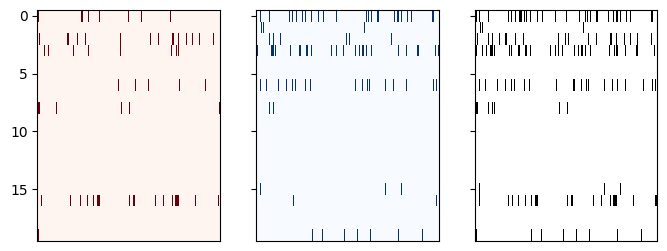

In [31]:
# Raster plot averaged over trials
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(8, 3))

time = np.arange(0, stim.shape[0]) * task_params["dt"]
cmaps = ["Reds", "Blues"]
ramp_up = int(20 / task_params["dt"])
n_trials = 10

summed_rasters = []
for  i, mean in enumerate([0.002, -0.002]):

    rasters = []
    for _ in tqdm(range(n_trials), desc=f"Mean: {mean}"):
        task_params["stim_mean"] = [mean, mean] # both either the positive or the negative   
        stim, target, mask = gen_stim(task_params)

        v = jitted_simulate(params, stim)

        # Raster plot of network activity
        raster = (v[:-n_readouts, ramp_up:] > 0.0).astype(int)
        rasters.append(raster)
    
    raster = np.sum(np.array(rasters), axis=0)
    raster = raster / n_trials
    summed_rasters.append(raster)

    raster_im = ax[i].matshow(raster, aspect="auto", cmap=cmaps[i], vmin=0, vmax=0.0001)
    ax[i].set_xticks([])

full_responses = np.sum(np.array(summed_rasters), axis=0)
ax[2].matshow(full_responses, aspect="auto", cmap="binary", vmin=0, vmax=0.0001)
ax[2].set_xticks([])

# Figure out the node indices that aren't spiking
non_spiking = np.where(np.sum(full_responses, axis=1) == 0)[0]
print(non_spiking)

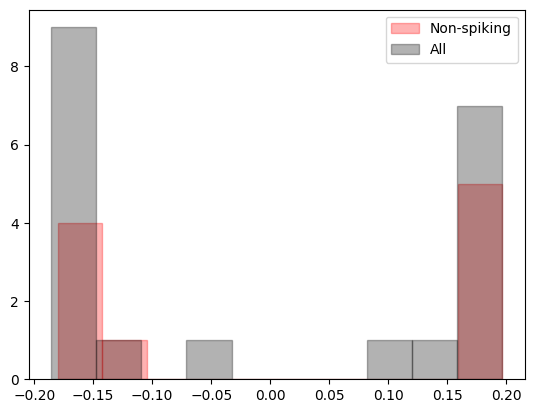

In [32]:
non_spiking_inps = params[0]['input_weights'][non_spiking]
plt.hist(non_spiking_inps, color="r", alpha=0.3, edgecolor="r", label="Non-spiking")
plt.hist(params[0]['input_weights'], color="k", alpha=0.3, edgecolor="k", label="All")
plt.legend()
plt.show()

31
69


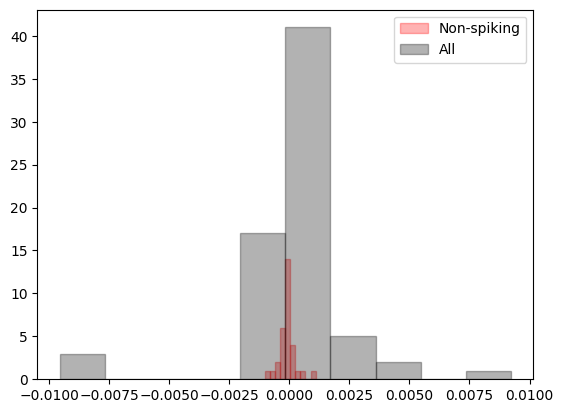

In [33]:
# Look at the recurrent inputs to the nonspiking neurons compared to the other neurons
nonspiking_rec_inps = final_conn_matrix[:-n_readouts, non_spiking]
nonspiking_rec_idxs = np.nonzero(nonspiking_rec_inps)
nonspiking_rec = nonspiking_rec_inps[nonspiking_rec_idxs]
print(len(nonspiking_rec))

all_rec = final_conn_matrix[:-n_readouts, :-n_readouts]
all_rec_idxs = np.nonzero(all_rec)
all_rec = all_rec[all_rec_idxs]
print(len(all_rec))

plt.hist(nonspiking_rec, color="r", alpha=0.3, edgecolor="r", label="Non-spiking")
plt.hist(all_rec, color="k", alpha=0.3, edgecolor="k", label="All")
plt.legend()
plt.show()

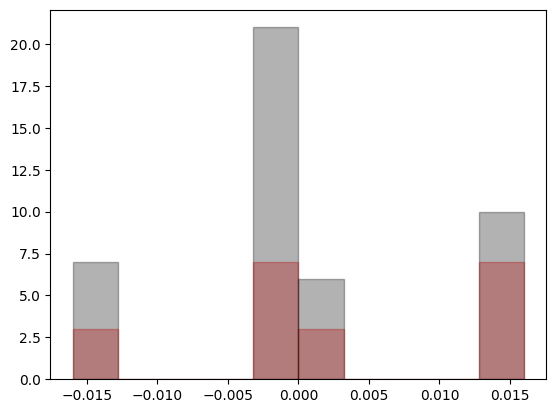

In [34]:
# Look at the output weights from the non-spiking neurons
nonspiking_outs = final_conn_matrix[non_spiking, -n_readouts:].flatten()
nonspiking_out_all = final_conn_matrix[:, -n_readouts:].flatten()

plt.figure()
plt.hist(nonspiking_outs, color="r", alpha=0.3, edgecolor="r", label="Non-spiking")
plt.hist(nonspiking_out_all, color="k", alpha=0.3, edgecolor="k", label="All")
plt.show()